<p align="center"> <img src="https://globalnews.ca/wp-content/uploads/2015/03/16779026680_1e8e89261a_o260570_high2.jpg?quality=85&strip=all"> </p>   

# Aviation incidents in Canada: 80 years of data  

## Introduction 
As stated by the **International Civil Aviation Organization** ([ICAO](https://www.iata.org/en/youandiata/travelers/aviation-safety/)), **safety** is the highest priority of all involved in aviation. The shared goal is for every flight to take-off and land safely, as happens more than 126,000 times every day. In 2018, the fatal accident rate was 0.28 per 1 million flights, the equivalent of one fatal accident for every 4.2 million flights.

Each fatality is a tragedy. And that rededicates everyone in the aviation industry to our common goal of having every flight take-off and land safely. 

The aviation industry is a complex collaboration of multiple fields. From manufacturers, to commercial airlines. The air traffic is regulated and managed by different agencies, and service providers.  

Data collection and analysis is a key factor in the safety management systems. It allows to investigate patterns and define efficient regulations and procedures.  

In **Canada**, aviation industry is regulated by [Transport Canada](https://tc.canada.ca/en). Air traffic services are offered by [Nav Canada](https://www.navcanada.ca/en/).  

Before diving into the data, let's define some terminology:
- **Occurrence**: Any event which is irregular, unplanned or non-routine in nature, including any aircraft accident, incident or other occurrence.
- **Accident**: An occurrence associated with the operation of an aircraft which takes place between the time any person boards the aircraft with the intention of flight until such time as all such persons have disembarked, in which:  
    1- a person is fatally or seriously injured  
    2- the aircraft sustains damage or structural failure  
    3- the aircraft is missing or is completely inaccessible.  

- **INCIDENT**: An occurrence, other than an accident, associated with the operation of an aircraft which affects or could affect the safety of operation.

- **SERIOUS INCIDENT**: An incident involving circumstances indicating that an accident nearly occurred.

## Purpose of this notebook  
In this notebook, we will analyse aviation occurrence data provided by [Transport Canada](https://www.bst-tsb.gc.ca/eng/stats/aviation/data-5.html). We will download the data, and after some cleaning and organizing, we will show plots of multiple aspect of these events.

In [1]:
# importing python libraries
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import numpy as np
import plotly.express as px
# Setting plots parameters
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Precisions about the datasets  
The data is divided into five (5) dataframes:  
- **Occurrence table**: This table contains data on the occurrence summary, including the date, time and location of the occurrence, the occurrence type and category, the occurrence classification, the aircraft involved, the number of injuries/or fatalities, the weather conditions, and data relating to the landing and takeoff aerodrome or operating surface.  
- **Aircraft table**: This table contains data on the occurrence aircraft, including its type, make, model, registration, and country of registration, aircraft’s engine(s), propellers, and rotors, data relating to any explosion, fire, fumes and/or smoke, operator information including type of operator, type of flight plan, flight number, departure and destination, and air traffic service involvement.  
- **Injuries table**: This table contains data on the number and severity of injuries resulting from the occurrence.  
- **Events and phases table**: This table contains data pertaining to the phases of the occurrence flight and the events during the flight.  
- **Survivability table**: This table contains data relating to the evacuation of the occurrence aircraft, the effectiveness of survival devices, and the systems for locating the occurrence aircraft.  

All these tables are available as `csv` files. `data_dictionary` table contains the definitions for each column in the dataframes.


## Downloading the data  
We use `urllib` library in order to download the `csv` files. We start by defining the different urls used in this project:

In [2]:
ref_url = 'https://www.bst-tsb.gc.ca/eng/stats/aviation/data-5.html'
data_dictionary_url = 'https://www.bst-tsb.gc.ca/eng/stats/aviation/csv/ASISdb-dd.csv'
occurence_table_url = 'https://www.bst-tsb.gc.ca/includes/stats/csv/Air/ASISdb_MDOTW_VW_OCCURRENCE_PUBLIC.csv'
aircraft_table_url = 'https://www.bst-tsb.gc.ca/includes/stats/csv/Air/ASISdb_MDOTW_VW_AIRCRAFT_PUBLIC.csv'
injuries_table_url = 'https://www.bst-tsb.gc.ca/includes/stats/csv/Air/ASISdb_MDOTW_VW_INJURIES_PUBLIC.csv'
events_phases_table_url = 'https://www.bst-tsb.gc.ca/includes/stats/csv/Air/ASISdb_MDOTW_VW_EVENTS_AND_PHASES_PUBLIC.csv'
survivability_table_url = 'https://www.bst-tsb.gc.ca/includes/stats/csv/Air/ASISdb_MDOTW_VW_SURVIVABILITY_PUBLIC.csv'

Now we download the datasets. The `if` blocs will test first if the files are already available, before initiating the download. We will perform a slight modification in order to tackle some encoding errors.

In [3]:
files = ['data_dict.csv','occurence.csv','aircraft.csv','injuries.csv','events_phases.csv','survivability.csv']
urls = [data_dictionary_url,occurence_table_url,aircraft_table_url,injuries_table_url,events_phases_table_url,survivability_table_url]
encoding = 'ISO-8859-1'
for filename,url in zip(files,urls):
    if filename not in os.listdir():
        print('Downloading', filename)
        urllib.request.urlretrieve(url, filename)
        # in order to avoid formatting errors, we have to replace all "–" by "-"
    print('formatting ',filename)    
    # Read in the file
    with open(filename, 'r', encoding=encoding) as file:
        filedata = file.read()

    #Replace the target string
    filedata = filedata.replace('â\x80\x93', '-')

    # Write the file out again
    with open(filename, 'w', encoding=encoding) as file:
        file.write(filedata)


formatting  data_dict.csv
formatting  occurence.csv
formatting  aircraft.csv
formatting  injuries.csv
formatting  events_phases.csv
formatting  survivability.csv


After looking into the files, I've decided to keep the following columns/files for this study: 

In [4]:
occurence_sel_columns = ['OccNo','CountryID_DisplayEng',
'ICAO_DisplayEng', 'OccDate', 'OccIncidentTypeID_DisplayEng', 'OccRegionID_DisplayEng', 'OccTime', 'OccTypeID_DisplayEng',
'TotalFatalCount','TotalSeriousCount',
'InjuriesEnum_DisplayEng', 'LightCondID_DisplayEng','SkyCondID_DisplayEng', 
'GeneralWeatherID_DisplayEng', 'VisibilyCeiling', 'Visibility', 'WeatherPhenomenaTypeID_DisplayEng', 'Summary',
'RunwaySurfaceID_DisplayEng', 'SurfaceContaminationID_DisplayEng','TimeZoneID_DisplayEng']
aircraft_sel_columns = ['OccNo','AircraftTypeID_DisplayEng', 'AircraftMakeID_DisplayEng',
'OperatorTypeID_DisplayEng', 'YearOfManuf','DamageLevelID_DisplayEng', 'FlightPlanTypeID_DisplayEng','OperationTypeID_DisplayEng', 'AircraftModelID_DisplayEng', 'OrganizationID_DisplayEng']
survivability_sel_columns = ['OccNo', 'SurvivableEnum_DisplayEng', 'AircraftEvacTime', 'EvacEgressIssueEnum_DisplayEng', 'SurvEquiID_DisplayEng', 'EquipEffReasonID_DisplayEng', 'EquipEffectiveEnum_DisplayEng','EquipInfluenceEnum_DisplayEng', 'EvacHamperedID_DisplayEng']
events_phases_sel_columns=['OccNo','PhaseID_DisplayEng'] 
injuries_sel_columns=['OccNo'] # place holder for future work

The library **Pandas** is used in order to read the `csv` files.

In [6]:
import warnings
warnings.filterwarnings("ignore")
data_dict_df = pd.read_csv('data_dict.csv',encoding = encoding)
occurence_df = pd.read_csv('occurence.csv',encoding = encoding,usecols=occurence_sel_columns)
aircraft_df = pd.read_csv('aircraft.csv',encoding = encoding, usecols=aircraft_sel_columns)
injuries_df = pd.read_csv('injuries.csv', encoding=encoding, usecols=injuries_sel_columns)
events_phases_df = pd.read_csv('events_phases.csv', encoding=encoding, usecols=events_phases_sel_columns)
survivability_df = pd.read_csv('survivability.csv', encoding=encoding, usecols=survivability_sel_columns)

Let's take a first look at the datasets:

In [7]:
print('Total number of columns',data_dict_df.shape[0])
print('Number of aviation occurrences',occurence_df.shape[0])

Total number of columns 514
Number of aviation occurrences 48843


There are around 500 different columns describing more than 45000 aviation events.   
  
  
Using `data_dict_df` dataframe, We can generate `html` that contains descriptions for each selected column. This will be added as a reference at the end of the notbook.

In [9]:
# uncomment this to generate html.
#for column in set(occurence_sel_columns + aircraft_sel_columns +injuries_sel_columns + events_phases_sel_columns + survivability_sel_columns) :
#    print('**'+column+'** ',':', data_dict_df[data_dict_df['Column name']==column]['Description English'].values[0],'<br>')

Occurrences have a unique number, stored in the column `OccNo`. This column is shared by all files, and will be used as a reference. Some occurrences appeared multiple times, in order to report different informations. We start first by creating two versions of the tables, a *full* version that contains duplicates, and a *clean* version without duplicates:

In [8]:
# remove duplicates from dataframe
occurence_df_full = occurence_df.copy()
occurence_df.drop_duplicates('OccNo', inplace=True)
survivability_df_full = survivability_df.copy()
survivability_df.drop_duplicates('OccNo', inplace=True)
aircraft_df_full = aircraft_df.copy()
aircraft_df.drop_duplicates('OccNo', inplace=True)
injuries_df_full = injuries_df.copy()
injuries_df.drop_duplicates('OccNo', inplace=True)
events_phases_df_full = events_phases_df.copy()
events_phases_df.drop_duplicates('OccNo', inplace=True)


Transport Canada classifies aviation occurrences by region, in order to specify the geographic area:
<p align="center"> <img src="https://tc.canada.ca/sites/default/files/migrated/map_of_canada2.gif"> </p>  
This plot will show the number of occurrences reported in every region:

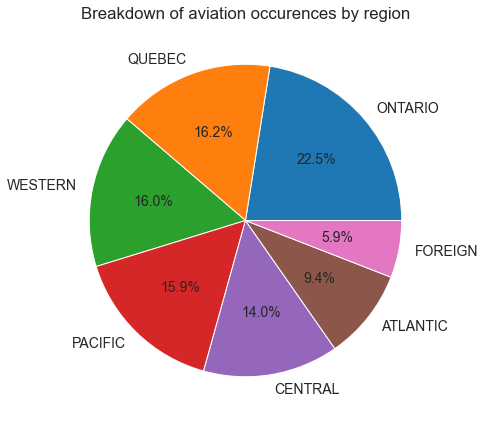

In [9]:
matplotlib.rcParams['figure.figsize'] = (7,57)
matplotlib.rcParams['font.size'] = 14
column = 'OccRegionID_DisplayEng'
graph =  occurence_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(7);
fig = graph.plot.pie(autopct="%.1f%%");
fig.set(ylabel = '',Title='Breakdown of aviation occurences by region');

More events were reported in **ONTARIO** compared to the rest of Canada. This is mainly due to the higher traffic density in this province, which is the most populous province in Canada. **FOREIGN** region refers to occurrences that happened outside Canada, involving canadian aircraft (manufactured, operated, etc). Let's  look at the countries where occurrences were reported:

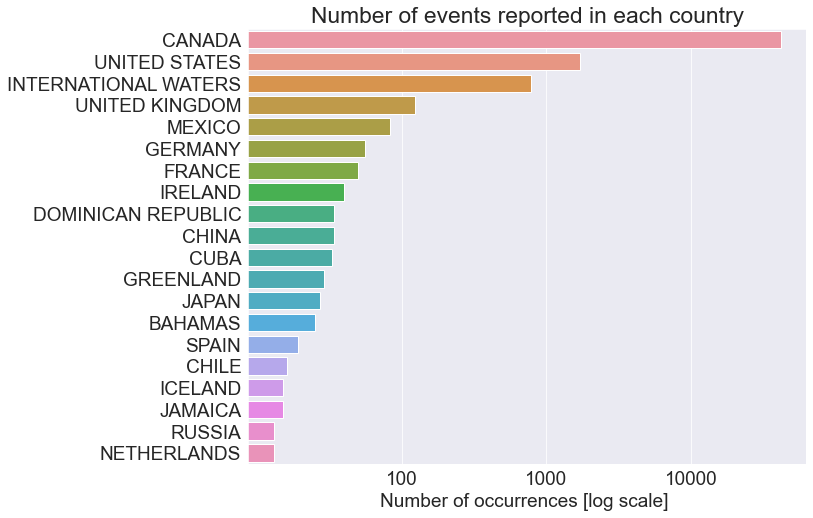

In [10]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['font.size'] = 19
column = 'CountryID_DisplayEng'
graph =  occurence_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(20)
fig = sns.barplot(graph.values, graph.index);
fig.set_xscale('log')
fig.set(xlabel = 'Number of occurrences [log scale] ', ylabel = '', Title='Number of events reported in each country');
fig.set_xticks([100,1000,10000]);
fig.set_xticklabels([100,1000,10000]);

In [11]:
canada_count = occurence_df[occurence_df[column]=='CANADA']['OccNo'].count()
total_count = occurence_df['OccNo'].count()
print('{} events happend in Canada out of {} occurrences ({:.2f}%).'.format(canada_count, total_count,100*canada_count/total_count))

41834 events happend in Canada out of 45277 occurrences (92.40%).


Most of the events (92%) happened in Canada.  
Each event is categorized, according to its main cause. The following plot shows the breakdown of events :

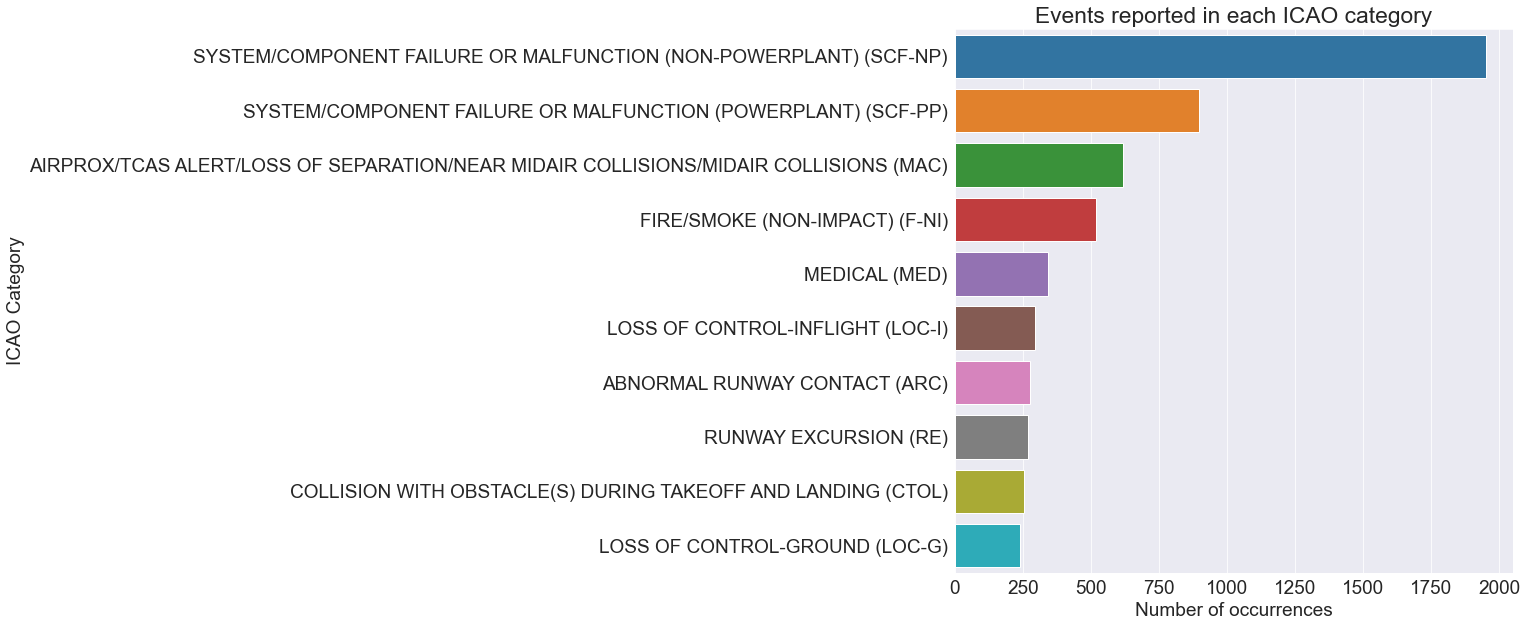

In [12]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
column = 'ICAO_DisplayEng'
graph =  occurence_df_full.groupby(column)['OccNo'].count().sort_values(ascending=False).head(10)
fig = sns.barplot(graph.values,graph.index);
fig.set(xlabel = 'Number of occurrences', ylabel = 'ICAO Category', Title='Events reported in each ICAO category');

Here is a breakdown of the top-10 occurrence categories (in %):

In [13]:
print('Events categories (%)')
print(round(graph.head(10)/graph.sum()*100,2))

Events categories (%)
ICAO_DisplayEng
SYSTEM/COMPONENT FAILURE OR MALFUNCTION (NON-POWERPLANT) (SCF-NP)                       34.50
SYSTEM/COMPONENT FAILURE OR MALFUNCTION (POWERPLANT) (SCF-PP)                           15.85
AIRPROX/TCAS ALERT/LOSS OF SEPARATION/NEAR MIDAIR COLLISIONS/MIDAIR COLLISIONS (MAC)    10.89
FIRE/SMOKE (NON-IMPACT) (F-NI)                                                           9.16
MEDICAL (MED)                                                                            6.03
LOSS OF CONTROL-INFLIGHT (LOC-I)                                                         5.20
ABNORMAL RUNWAY CONTACT (ARC)                                                            4.86
RUNWAY EXCURSION (RE)                                                                    4.77
COLLISION WITH OBSTACLE(S) DURING TAKEOFF AND LANDING (CTOL)                             4.51
LOSS OF CONTROL-GROUND (LOC-G)                                                           4.24
Name: OccNo, dtype: fl

Note that the incident category data is missing in most of the records:

In [14]:
print(occurence_df_full['ICAO_DisplayEng'].isna().sum(),'missing records out of {}.'.format(total_count))

41703 missing records out of 45277.


System failures (related or not to engines) are the most common causes of occurences.  

Date information requires some manipulation in order to extract interesting data.

In [15]:
occurence_df['OccDate'] = pd.to_datetime(occurence_df['OccDate'])
occurence_df['OccYear'] = occurence_df['OccDate'].dt.year
occurence_df['OccMonth'] = occurence_df['OccDate'].dt.month
occurence_df['OccWeekday'] = occurence_df['OccDate'].dt.weekday

Our first plot will show the number of events reported every year.

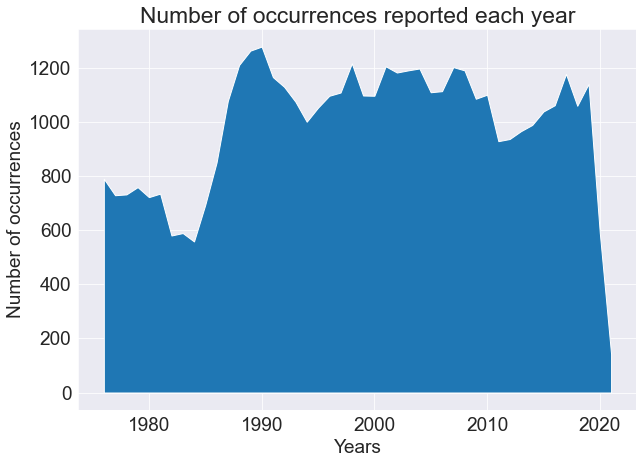

In [16]:
matplotlib.rcParams['figure.figsize'] = (10, 7)
column = 'OccYear'
data = occurence_df[occurence_df[column]>1965].dropna(subset=[column])
data2= data.groupby(column)['OccNo'].count()
plt.fill_between(data2.index, data2.values);
plt.xlabel('Years');
plt.ylabel('Number of occurrences');
plt.title('Number of occurrences reported each year');


We have excluded events prior to 1965 due to the low number of reported events. The number of occurrences seems to be steady since the 90s, with a slight tendency to decrease. An interesting comparison would include the total number of aircraft movements. Using [Statcan website](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2310000201&pickMembers%5B0%5D=2.1&pickMembers%5B1%5D=4.2&cubeTimeFrame.startMonth=01&cubeTimeFrame.startYear=1997&cubeTimeFrame.endMonth=04&cubeTimeFrame.endYear=2021&referencePeriods=19970101%2C20210401), we can observe that the number of movements is not increasing (at least since 1997, if we exclude 2020 and 2021 due to covid-19 crisis). 

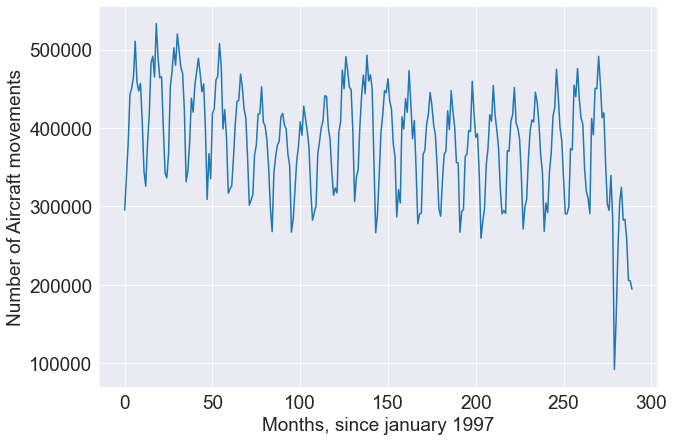

In [17]:
#ref: StatCan website : https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2310001801&pickMembers%5B0%5D=1.1&cubeTimeFrame.startYear=1997&cubeTimeFrame.endYear=2018&referencePeriods=19970101%2C20180101
total_traffic_per_month = [295073,337146,380552,442854,450516,464973,510697,458663,447297,456912,407902,344482,325659,380045,417183,482710,491502,464962,533190,489821,463890,465243,400306,342608,336128,366646,452346,472217,502205,479946,519847,498412,477100,469594,422355,331220,345760,381111,437902,420143,454782,472125,488821,469541,446128,456177,398326,308714,367114,335254,418483,424343,460960,465684,507708,478667,398620,423309,387907,316658,322265,326231,362693,405125,433683,435156,468725,452305,424170,412831,363115,301364,307702,314836,365905,378116,417552,418059,452675,407577,402467,384931,350045,298217,267541,342664,363529,378121,382597,413927,418497,403773,398083,366234,352016,266931,283328,319662,358132,376230,407889,390620,427859,411896,396070,374974,319636,282289,291797,300182,366577,382264,400425,409285,441021,440333,400522,385201,343793,314044,323338,316990,394955,407534,473718,449994,490882,473606,451913,448830,395144,305836,336956,346748,402155,442058,467391,443741,492754,459748,467978,449438,358436,266203,289420,339228,394607,416342,447574,444682,462781,434142,423997,379867,363273,286269,321061,304147,413944,398521,437358,419919,473132,432291,386163,409364,348383,277661,290037,291483,366283,371370,404122,417210,445231,428915,404187,391091,351734,296863,287259,331536,366189,370297,421938,397728,447536,421029,400788,355873,355214,266787,293116,295953,363491,366338,396742,395670,459494,419687,387989,392543,341189,259238,280830,297214,352957,374535,416872,408643,454126,416991,397643,374009,321259,290319,294544,290853,371033,370288,408358,416629,451495,406442,399377,385502,338086,270894,299222,308524,360373,396811,410145,407532,445571,432552,405965,364946,343035,267840,304166,291847,344150,367705,414790,425777,474985,440303,400950,383760,336210,290225,290320,298983,373493,371989,454638,439791,475931,436955,412189,405096,348431,319111,310268,290654,412066,391156,450495,450060,491377,456956,412919,419319,352500,302368,294785,339424,285335,91600,157118,244049,304795,324274,282202,283235,258053,205465,204773,194127]
matplotlib.rcParams['figure.figsize'] = (10, 7);
plt.plot(total_traffic_per_month);
plt.xlabel('Months, since january 1997');
plt.ylabel('Number of Aircraft movements');

Note that this graph only shows the number of movements at airports, and not the number of passengers. Using the two plots, we could infer that the number of events is somewhat constant with regard to traffic density.  
  
    
In the following plot we answer the question: are there periods of the year where more events take place ?

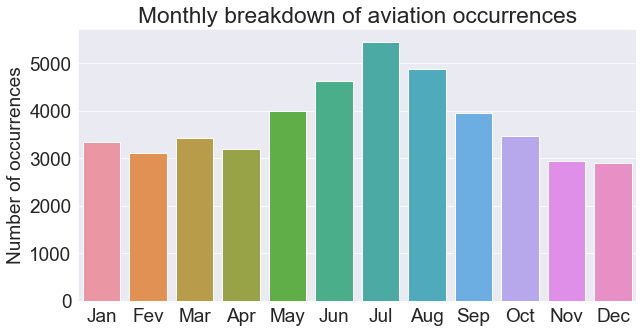

In [18]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OccMonth'
fig = sns.countplot(x=column, data = occurence_df.dropna(subset=[column]));
fig.set(xlabel = '', ylabel = 'Number of occurrences', Title='Monthly breakdown of aviation occurrences');
months = ['Jan','Fev','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig.set_xticklabels(months);

And the answer is Yes! It appears that more events happen during summer months (5,6,7,8). This can be due to  higher density of traffic during summer. The previous graph confirms this cyclical pattern of traffic.  

Is there a similar pattern if we consider weekdays ?

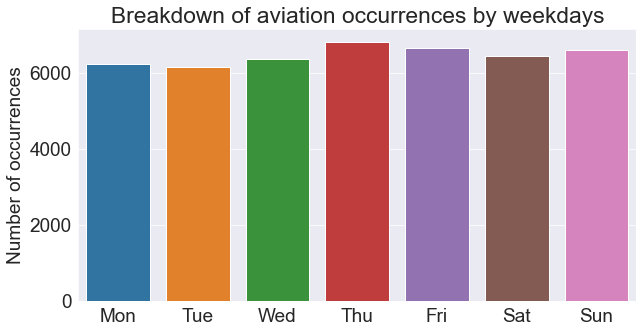

In [19]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OccWeekday'
fig = sns.countplot(x=column, data = occurence_df.dropna(subset=[column]));
fig.set(xlabel = '', ylabel = 'Number of occurrences', Title='Breakdown of aviation occurrences by weekdays');
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
fig.set_xticklabels(days);

The result shows that there is no obvious correlation between the number of events and weekdays. Later on, we will show that some categories of incidents happen more frequently during weekends.  
  
Next, we look at the incident type breakdown (as defined by Transportation Safety Board).

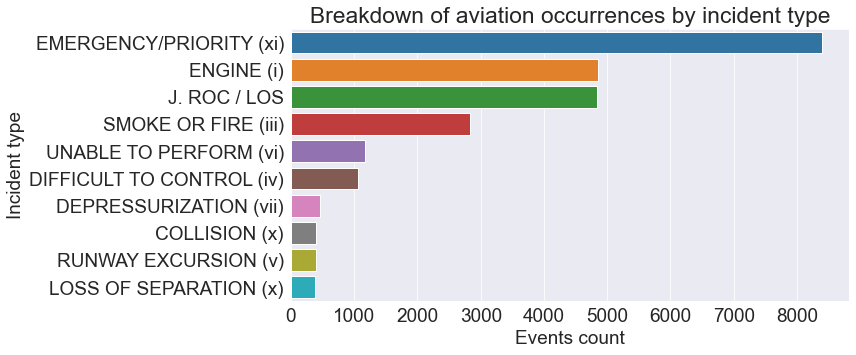

In [20]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OccIncidentTypeID_DisplayEng'
graph =  occurence_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(10)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = 'Incident type', Title='Breakdown of aviation occurrences by incident type');

In contrast to the incident category used in a previous plot, this column is missing less data.

In [21]:
print(occurence_df_full['OccIncidentTypeID_DisplayEng'].isna().sum(),'missing records out of {}.'.format(total_count))

22399 missing records out of 45277.


This is still close to 50% of missing data. Nonetheless, we can observe that emergencies are the top category of incidents.  
  
In aviation, time is usually provided in UTC (GMT) standard format. In Canada, this information cannot give an direct intuition about the time of day, due to the large area of the country. In our dataset, some of the events are not reported in UTC time. Let's take a look at the breakdown of these occurrences.

In [22]:
occurence_df['OccTime'] = pd.to_datetime(occurence_df['OccTime'])
occurence_df['OccHour'] = occurence_df['OccTime'].dt.hour

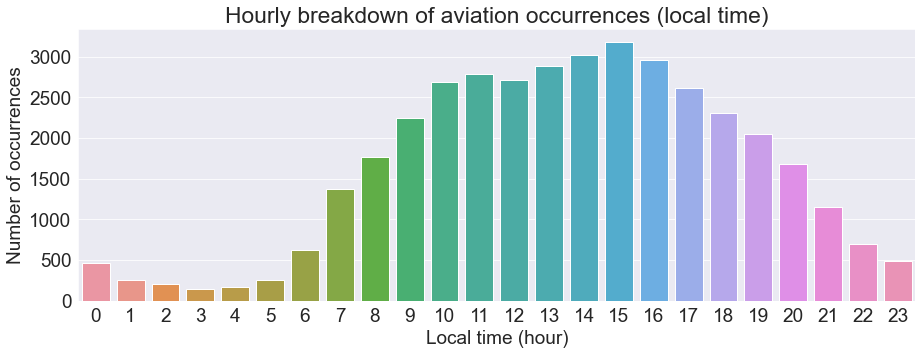

In [23]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'OccHour'
fig = sns.countplot(x=column, data = occurence_df[occurence_df['TimeZoneID_DisplayEng'] !='UTC'].dropna(subset=[column]));
fig.set(xlabel = 'Local time (hour)', ylabel = 'Number of occurrences', Title='Hourly breakdown of aviation occurrences (local time)');
fig.set_xticklabels(np.arange(0,24));

It comes out that most occurrences happen during daytime. Obviously, traffic density during day is higher, and the risk of incident increases.  
Next, we look at the incident/accident breakdown.

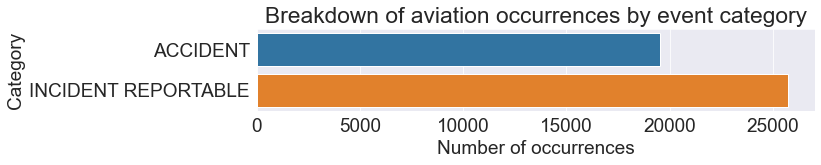

In [24]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'OccTypeID_DisplayEng'
fig = sns.countplot(y=column, data = occurence_df.dropna(subset=[column]));
fig.set(xlabel = 'Number of occurrences', ylabel = 'Category', Title='Breakdown of aviation occurrences by event category');

Statistically, there are more incidents (not involving fatal injuries, or aircraft damage) than accidents. With that being said, about 40% of events are categorized as accidents. Let's see how this rate is evoloving with time.

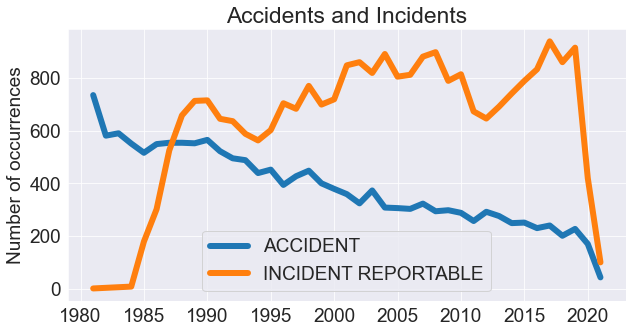

In [25]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OccYear'
sub_occ1 = occurence_df[occurence_df['OccTypeID_DisplayEng']=='ACCIDENT']
sub_occ2 = occurence_df[occurence_df['OccTypeID_DisplayEng']=='INCIDENT REPORTABLE']

data = sub_occ1[sub_occ1[column]>1980].dropna(subset=[column])
data2 = data.groupby(column)['OccNo'].count()

data3 = sub_occ2[sub_occ2[column]>1980].dropna(subset=[column])
data4 = data3.groupby(column)['OccNo'].count()

plt.plot(data2.index, data2.values, label='ACCIDENT',linewidth=6);
plt.plot(data4.index, data4.values, label = 'INCIDENT REPORTABLE',linewidth=6);

plt.ylabel('Number of occurrences');
plt.title('Accidents and Incidents');
plt.legend();

The result is encouraging! the rate of accidents among the reported events is decreasing. This means that there are less fatal injuries and substantial damages.  
  
Let's focus now on the accidents, and plot the number of deaths reported every year:

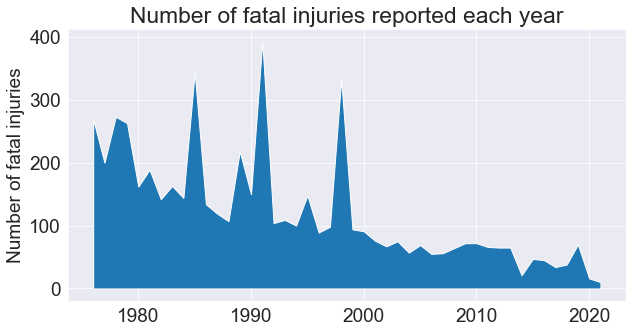

In [26]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OccYear'
data = occurence_df[occurence_df[column]>1965].dropna(subset=[column])
data2= data.groupby(column)['TotalFatalCount'].sum()
plt.fill_between(data2.index, data2.values);
plt.ylabel('Number of fatal injuries');
plt.title('Number of fatal injuries reported each year');

The general trend is downward (which is good news). There are still some peaks in this graph that need further investigation. Those values are due to crashes that caused a high number of fatal injuries. Let's look for more details:

In [27]:
# 10 worst accidents, by death count
data = occurence_df.sort_values('TotalFatalCount',ascending=False)[['OccDate','TotalFatalCount','OccNo','CountryID_DisplayEng']].head(10)
OccNos = data['OccNo'].values
print(list(data.columns),'[AircraftModelID_DisplayEng','OrganizationID_DisplayEng]')
for OccNo in OccNos:
    print(data[data['OccNo']==OccNo].values, aircraft_df[aircraft_df['OccNo']==OccNo][['AircraftModelID_DisplayEng','OrganizationID_DisplayEng']].values)

['OccDate', 'TotalFatalCount', 'OccNo', 'CountryID_DisplayEng'] [AircraftModelID_DisplayEng OrganizationID_DisplayEng]
[[Timestamp('1991-07-11 00:00:00') 261 'A91F0011' 'SAUDI ARABIA']] [['DC-8-61' 'NATIONAIR (NOLISAIR)']]
[[Timestamp('1985-12-12 00:00:00') 256 'A85H0902' 'CANADA']] [['DC-8-63' 'ARROW AIR']]
[[Timestamp('1998-09-02 00:00:00') 229 'A98H0003' 'CANADA']] [['MD-11' 'SWISSAIR']]
[[Timestamp('1976-01-01 00:00:00') 62 'A76P7962' 'CANADA']] [['DC-4M2' nan]]
[[Timestamp('1989-09-08 00:00:00') 55 'A89H0011' 'DENMARK']] [['CV580' 'PARTNAIR']]
[[Timestamp('1978-02-11 00:00:00') 43 'A78H0001' 'CANADA']] [['737-200' 'PACIFIC WESTERN AIRLINES']]
[[Timestamp('1989-03-10 00:00:00') 24 'A89C0048' 'CANADA']] [['F-28 MK 1000' 'AIR ONTARIO']]
[[Timestamp('1983-06-02 00:00:00') 23 'A83F0006' 'UNITED STATES']] [['DC-9-32' 'AIR CANADA']]
[[Timestamp('1990-04-18 00:00:00') 20 'A90H0004' 'PANAMA']] [['DHC-6-200' 'AEROPERLAS S.A.']]
[[Timestamp('1990-09-11 00:00:00') 18 'A90A0214' 'INTERNATIONAL

We can see that the top 3 accidents happened in 1985,1991 and 1998. These correspond to the peaks in our graph. Let's get more details about these accidents.

In [28]:
### let's consider the top 3
dates = [1985,1991,1998]
fatal_accidents = []
for date in dates:
    fatal_accidents.append(occurence_df[occurence_df['OccYear']==date]['TotalFatalCount'].max())

for fatal in fatal_accidents:
    OccNo = occurence_df[occurence_df['TotalFatalCount']==fatal]['OccNo']
    event = occurence_df[occurence_df['OccNo']==OccNo.values[0]]['Summary'].values[0]
    aircraft = aircraft_df[aircraft_df['OccNo']==OccNo.values[0]]['AircraftModelID_DisplayEng'].values[0]
    date = occurence_df[occurence_df['OccNo']==OccNo.values[0]]['OccDate'].values[0]
    print('Date: {} - {} deaths - Aircraft type: {}.\nEvent# {}\n'.format(str(date)[:10],fatal,
    aircraft,event))



Date: 1985-12-12 - 256 deaths - Aircraft type: DC-8-63.
Event# A85H0902: AIRCRAFT CRASHED ON TAKE-OFF, APPROXIMATELY ONE-HALF MILE BEYOND THE DEPARTURE END OF RUNWAY 22. THE AIRCRAFT WAS DESTROYED BY IMPACT FORCES AND A POST-CRASH FIRE.     

Date: 1991-07-11 - 261 deaths - Aircraft type: DC-8-61.
Event# A91F0011: THE NATIONAR DC-8 WAS RETURNING TO LAND SHORTLY AFTER TAKE-OFF FROM KING ABDUL AZZIZ INTERNATIONAL AIRPORT IN SAUDI ARABIA AND CRASHED ABOUT ONE MILE ON FINAL APPROACH FOR RUNWAY 34C.  THE AIRCRAFT WAS DESTROYED IN THE CRASH AND THERE WERE NO SURVIVORS.THE PRESIDENCY OF CIVIL AVIATION OF SAUDI ARABIA IS CONDUCTING THE INVESTIGATION.  RON COLEMAN HAS BEEN APPOINTED CANADIAN ACCREDITED REPRESENTATIVE.

Date: 1998-09-02 - 229 deaths - Aircraft type: MD-11.
Event# A98H0003: At 0018 UTC, a Swissair MD-11 (SR 111) departed New York, USA, for Geneva, Switzerland, with 215 passengers and 14 crew members on board.  About 53 minutes after departure, the pilots detected an odour in the 

Statistically, those events can be considered as outliers. They affect significantly the properties of the dataset. For instance, here is a plot of average fatal injuries count for each month:

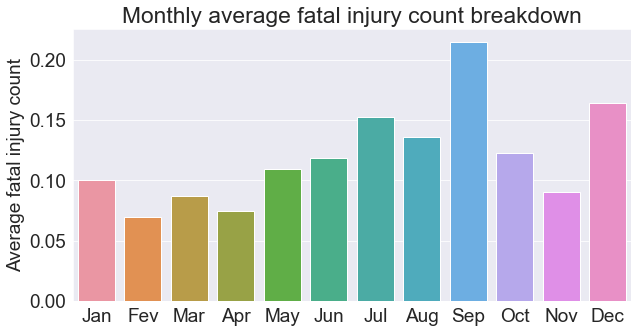

In [29]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
data = occurence_df.groupby('OccMonth').TotalFatalCount.mean()
fig = sns.barplot(x = data.index, y = data.values);
fig.set(xlabel = '', ylabel = 'Average fatal injury count', Title='Monthly average fatal injury count breakdown');
fig.set_xticklabels(months);

We can see clearly peaks in jully, september and december, where the three worst accidents happend.  
  
    
The same investigation can be applied to serious injuries. The results are shown in the following plot: 

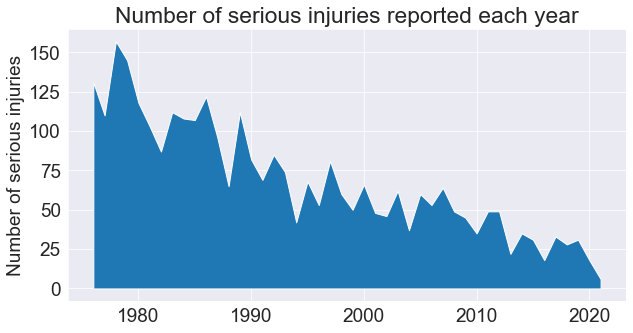

In [30]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OccYear'
data = occurence_df[occurence_df[column]>1965].dropna(subset=[column])
data2= data.groupby(column)['TotalSeriousCount'].sum()
plt.fill_between(data2.index, data2.values);
plt.ylabel('Number of serious injuries');
plt.title('Number of serious injuries reported each year');

The downward trend is also visible in this plot. New technologies, and new regulations are improving the safety of air travel, in addition to more sophisticated search and rescue services. Curiously, the worst 3 accidents we have shown earlier, didn't affect the number of serious injuries. Sadly, these events reported a low number of survivors.  

Ther is an interesting relationship between the average number of serious injuries and the weekdays: 

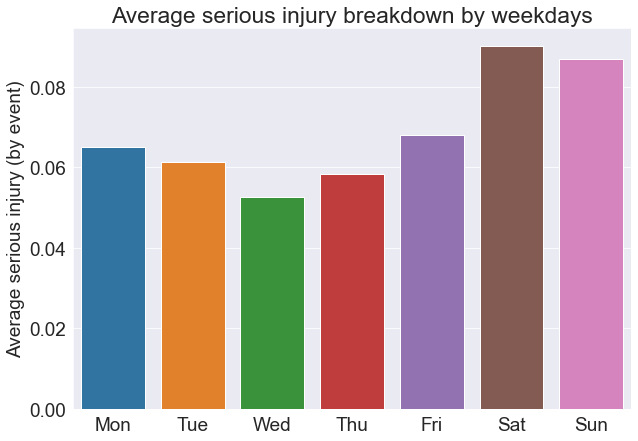

In [31]:
matplotlib.rcParams['figure.figsize'] = (10, 7)
data = occurence_df.groupby('OccWeekday').TotalSeriousCount.mean()
fig = sns.barplot(x = data.index, y = data.values);
fig.set(xlabel = '', ylabel = 'Average serious injury (by event)', Title='Average serious injury breakdown by weekdays');
fig.set_xticklabels(days);

It appears that more serious injuries happen on weekends. More investigation is required to determine the real reasons of such a trend.

Do light conditions and affect aviation safety? let's look at the next graph:

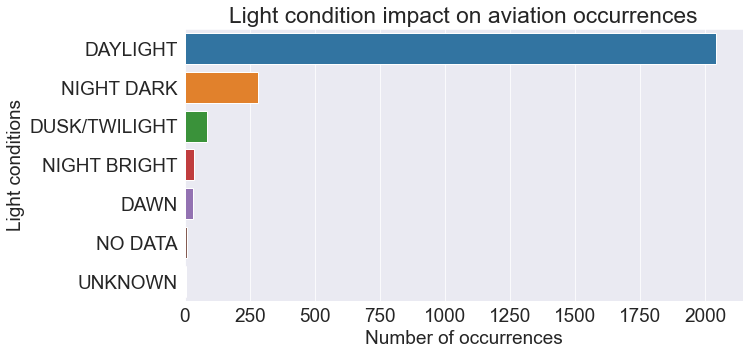

In [32]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'LightCondID_DisplayEng'
graph =  occurence_df.groupby(column)['OccNo'].count().sort_values(ascending=False)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Number of occurrences', ylabel = 'Light conditions', Title='Light condition impact on aviation occurrences');


The data is missing most of the rows. Based on what is available, most events occured during daylight.  
Let's plot a similar graph for sky conditions: 

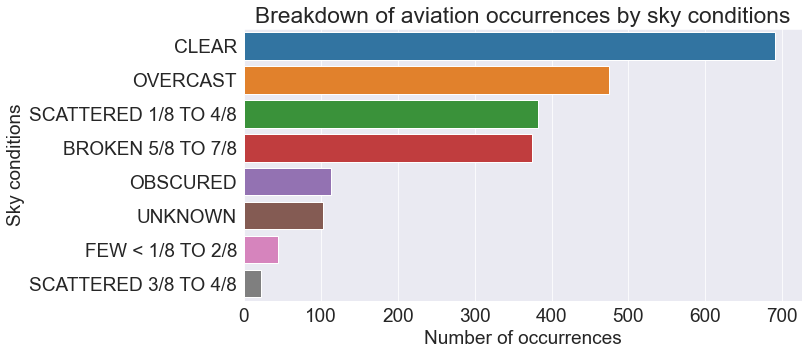

In [33]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'SkyCondID_DisplayEng'
graph =  occurence_df.groupby(column)['OccNo'].count().sort_values(ascending=False)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Number of occurrences', ylabel = 'Sky conditions', Title='Breakdown of aviation occurrences by sky conditions');


Based on this data, it appears that occurrences happen more often in clear sky.  

Another weather-related parameter is the visual (VMC)/instrument (IMC) weather condition. According to canadian regulations, this refers to visibility being above or less than 3 nautical miles. Definition can vary in other countries.

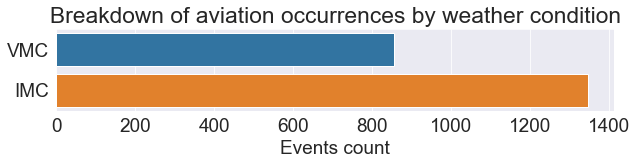

In [34]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'GeneralWeatherID_DisplayEng'
fig= sns.countplot(y=column, data = occurence_df[occurence_df[column]!='UNKNOWN'].dropna(subset=[column]));
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation occurrences by weather condition');

In the next plot, we look for the relationship between the visibility ceiling (vertical visibility), visibility (horizontal visibility) and the number of events.

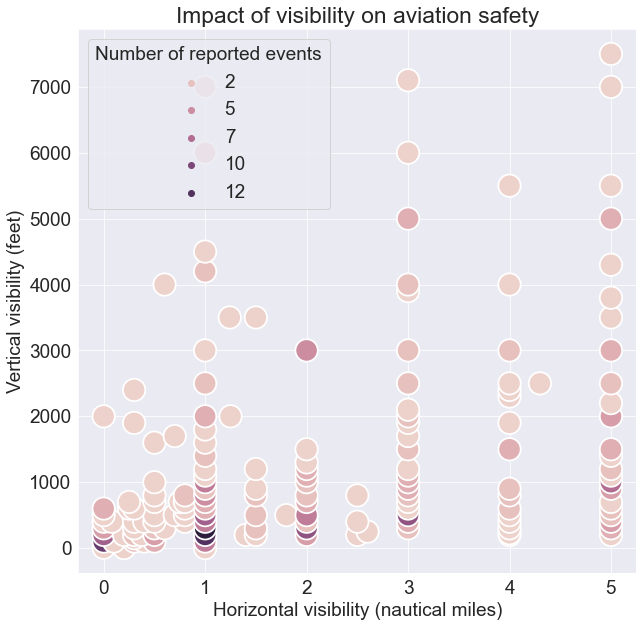

In [35]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
data = occurence_df[occurence_df['VisibilyCeiling']<8000]
data = data[data['Visibility']<6]
data = data.groupby(['VisibilyCeiling','Visibility'])['OccNo'].count()
fig = sns.scatterplot(y ='VisibilyCeiling',x='Visibility', hue = data.values, data =data,s=500);
fig.set(ylabel = 'Vertical visibility (feet)', xlabel = 'Horizontal visibility (nautical miles)', Title='Impact of visibility on aviation safety');
fig.legend(title='Number of reported events');

Aviation accidents and incidents are more likely to happen in low visibility conditions. This conditions are usually refered to as **marginal** and can change quickly. They affect mainly VFR (visual flight rules) aircraft that are not certified and equipped to fly IFR (instrument flight rules).  
Other weather phenomena have an impact on flight safety. The following plot is a breakdown of aviation events with respect to associated phenomenon (or multiple phenomena).

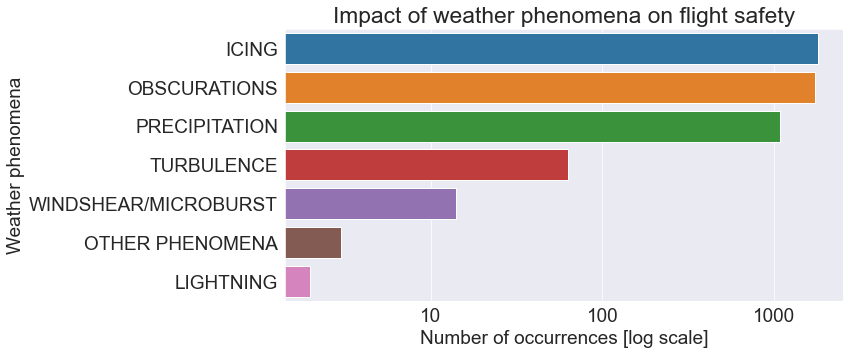

In [36]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'WeatherPhenomenaTypeID_DisplayEng'
graph =  occurence_df_full.groupby(column)['OccNo'].count().sort_values(ascending=False).head(7)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Number of occurrences [log scale]', ylabel = 'Weather phenomena', Title='Impact of weather phenomena on flight safety');
fig.set_xscale('log')
fig.set_xticks([10,100,1000]);
fig.set_xticklabels([10,100,1000]);

The top 3 weather conditions affecting aviation are **icing**, **obscuration** and **precipitation**. **Turbulence** is a very serious concern, especially when it is categorized as *moderate* or *severe*. Among the less recurrent but most dangerous phenomena are **windshear**, **Microburst** and **lightning**. These three conditions are difficult to forecast and can cause substantial damages in short time duration.  
  
The flight phases have a key influence on the outcome of events. Let's take a look at the breakdown of incidents by phase.

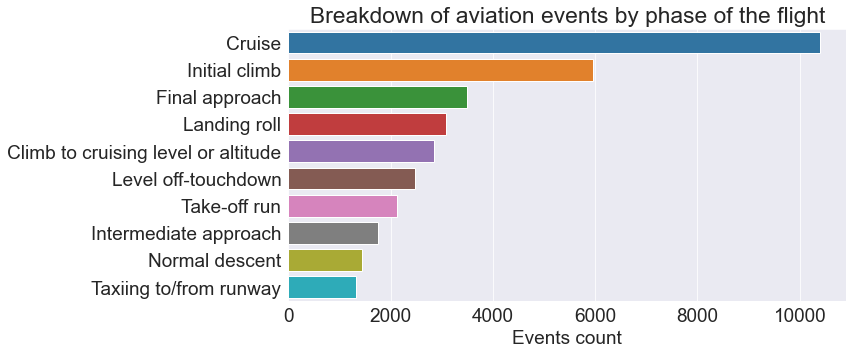

In [37]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'PhaseID_DisplayEng'
graph =  events_phases_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(10)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation events by phase of the flight');

It turns out that more events happened during the cruise phase. Which events are more dangerous ? (by dangerous, we mean cause more fatal injuries)

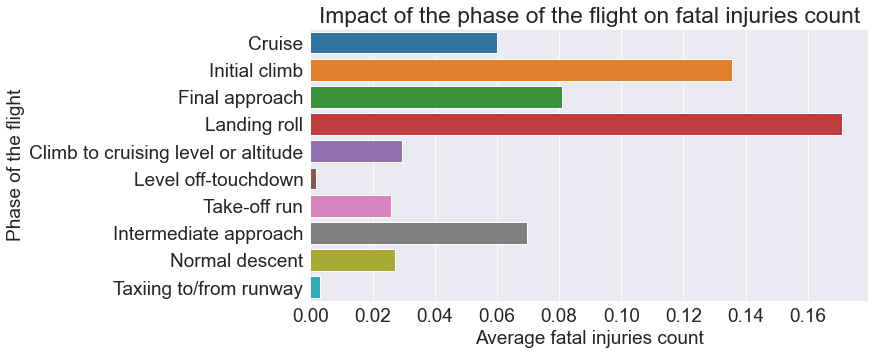

In [38]:
#we join the occurrence and events_phases datasets using the occurrence numbers.
new_dataset3 = occurence_df.set_index('OccNo').join(events_phases_df.set_index('OccNo'))
select_phases = graph.index
data = new_dataset3.loc[(new_dataset3['PhaseID_DisplayEng']==select_phases[0])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[1])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[2])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[3])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[4])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[5])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[6])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[7])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[8])|
                (new_dataset3['PhaseID_DisplayEng']==select_phases[9])].groupby('PhaseID_DisplayEng')                          ['TotalFatalCount'].mean()
matplotlib.rcParams['figure.figsize'] = (10, 5)
fig = sns.barplot( data.values,select_phases);
fig.set(xlabel = 'Average fatal injuries count', ylabel = 'Phase of the flight', Title='Impact of the phase of the flight on fatal injuries count');


The accidents causing more fatal injuries happen in general during the begining of the flight (Initial climb) and the last minutes of the flight (Final approach, Landing roll).  

When we consider takeoff and landing operations, it is clear that the runway plays a key role. Runway surface can be described using two parameters : *surface condition* and *contamination*.

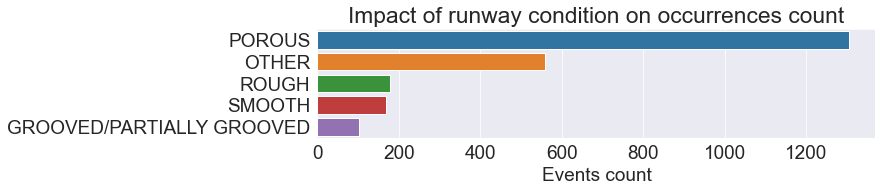

In [39]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'RunwaySurfaceID_DisplayEng'
graph =  occurence_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(5)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Impact of runway condition on occurrences count');

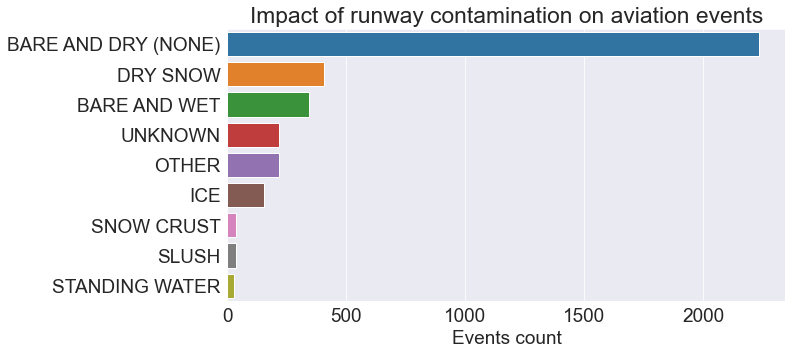

In [40]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'SurfaceContaminationID_DisplayEng'
graph =  occurence_df_full.groupby(column)['OccNo'].count().sort_values(ascending=False).head(9)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Impact of runway contamination on aviation events');

Even if the contamination affects the runway operation, we can observe that a high number of events occur in *bare and dry* runways. In this case, human or equipment factors must be considered.  
  
Let's see if a specific aircraft manufacturer is more represented in the incident/accident database:

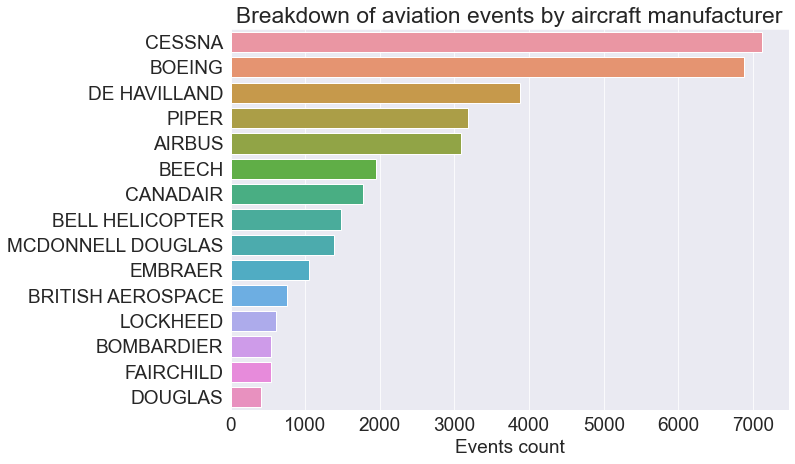

In [41]:
matplotlib.rcParams['figure.figsize'] = (10, 7)
column = 'AircraftMakeID_DisplayEng'
graph =  aircraft_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(15)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation events by aircraft manufacturer');

**Cessna** and **Piper** show among the top 5 manufacturers. Most of aircraft produced by these two makes are light aircraft used for personal/tourism and training flights. Pilots flying these aircraft are less experienced in average. There are many occurrences invloving aircraft made by **Boeing**, **Airbus** and **De Havilland**. These aircraft are the most used by canadian commercial aviation.  

Aviation events are not reported only for airplanes, but for all types of aircraft. Here is a breakdown of events by aircraft types: 

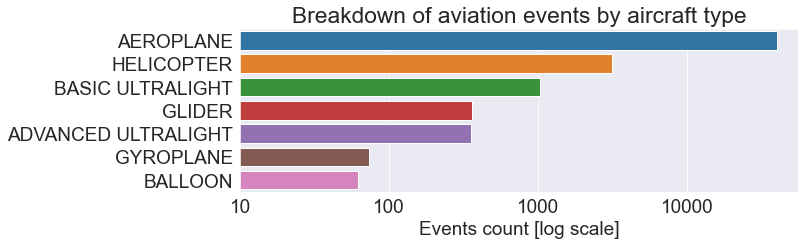

In [42]:
matplotlib.rcParams['figure.figsize'] = (10, 3)
column = 'AircraftTypeID_DisplayEng'
graph =  aircraft_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(7)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count [log scale]', ylabel = '', Title='Breakdown of aviation events by aircraft type');
fig.set_xscale('log')
fig.set_xticks([10,100,1000,10000]);
fig.set_xticklabels([10,100,1000,10000]);

Most of events are related to **airplanes** obviously, there are still a non neglectable amount of events happening with **helicopters, gliders**, and even **ballons** !  

Events can be classified as well, according to their operator type:

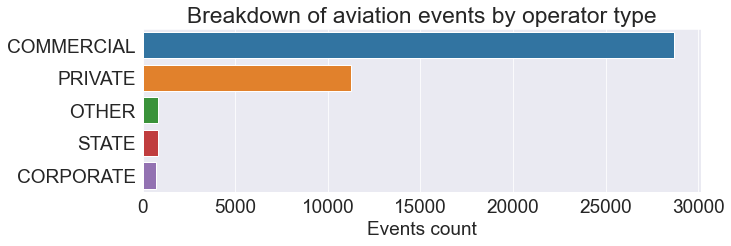

In [43]:
matplotlib.rcParams['figure.figsize'] = (10, 3)
column = 'OperatorTypeID_DisplayEng'
graph =  aircraft_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(5)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation events by operator type');

**Commercial** flights report the highest number of events, due to more intense activity. **Private** flights are more related to tourism, and training activities.  

In the next section, we will determine the impact of the aircraft age on the events count. Using the `YearOfManuf` column, we will compute the age at the time of the event. First we have to prepare/clean the data.

In [44]:
def clean_YoM(txt):
    txt = str(txt)
    if len(txt)==4 and txt[0]!=' ':
        return int(txt)
    elif len(txt)==6:
        return int(txt[:-2])

column = 'YearOfManuf'
aircraft_df[column] = aircraft_df[column].apply(clean_YoM)

In [45]:
#we join the occurrence and aircraft datasets using the occurrence numbers.
new_dataset = aircraft_df.set_index('OccNo').join(occurence_df.set_index('OccNo'))
#compute the age
new_dataset['age'] = new_dataset['OccYear']-new_dataset['YearOfManuf']

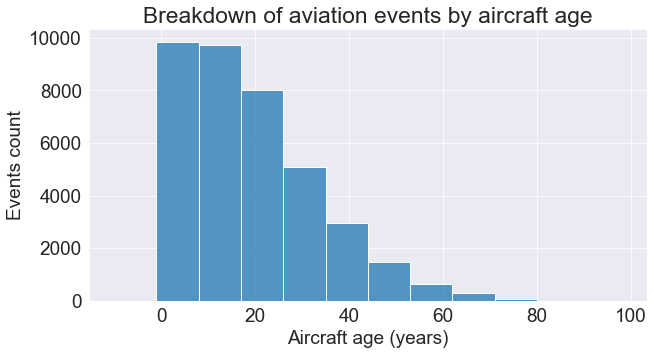

In [46]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'age'
fig = sns.histplot(x = column, data = new_dataset, bins=12);
fig.set(xlabel = 'Aircraft age (years)', ylabel = 'Events count', Title='Breakdown of aviation events by aircraft age');

This histogram shows that -in general- incidents/accidents are not more frequent in old aircraft. This can be associated with two factors:  
- There are less old aircraft, so less events associated with this category.
- Airworthiness and strict maintenance programs allow to keep aircraft in very good condition.
  
Not all occurrences lead to aircraft damage. The next plot shows a breakdown by damage level.

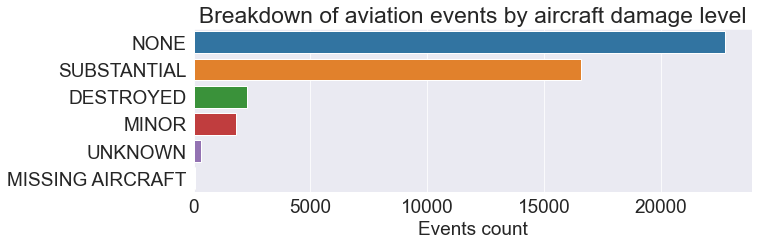

In [47]:
matplotlib.rcParams['figure.figsize'] = (10, 3)
column = 'DamageLevelID_DisplayEng'
graph =  aircraft_df.groupby(column)['OccNo'].count().sort_values(ascending=False)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation events by aircraft damage level');

Most of events caused no damage. It turns out that, **if an aircraft is damaged during an event**, it is more likely that the damage is substantial.  
  
  
Flight plans are documents filed by a pilot or flight dispatcher with the local Air Navigation Service Provider prior to departure which indicate the plane's planned route or flight path. Flight plans are required in some cases (IFR, VFR cross border, etc). They contain important data about the flight originating airport, route, destination airport, altitude and aircraft type. They contain also contact informations and search and rescue time. 

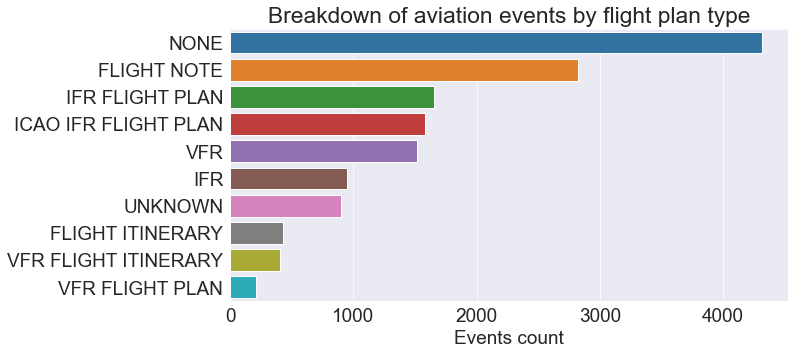

In [48]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'FlightPlanTypeID_DisplayEng'
graph =  aircraft_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(10)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation events by flight plan type');

The top-two categories of flights involved in events are :
- flights without flight plan,
- flight notes, where the pilot is responsible of search and rescue  
  
Furthermore, we can prove that the average fatal injuries count is *lower* when flight plans are available.

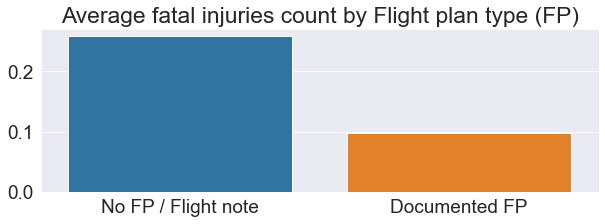

In [49]:
mean_fatal_no_fp = new_dataset.loc[(new_dataset['FlightPlanTypeID_DisplayEng']=='NONE')|(new_dataset['FlightPlanTypeID_DisplayEng']=='FLIGHT NOTE')]['TotalFatalCount'].mean()

mean_fatal_with_fp = new_dataset.loc[(new_dataset['FlightPlanTypeID_DisplayEng']!='NONE')&(new_dataset['FlightPlanTypeID_DisplayEng']!='FLIGHT NOTE')]['TotalFatalCount'].mean()

matplotlib.rcParams['figure.figsize'] = (10, 3)
fig = sns.barplot(['No FP / Flight note','Documented FP'],[mean_fatal_no_fp,mean_fatal_with_fp]);
fig.set(xlabel = '', ylabel = '', Title='Average fatal injuries count by Flight plan type (FP)');

The next plot shows the breakdown of events by operation type.

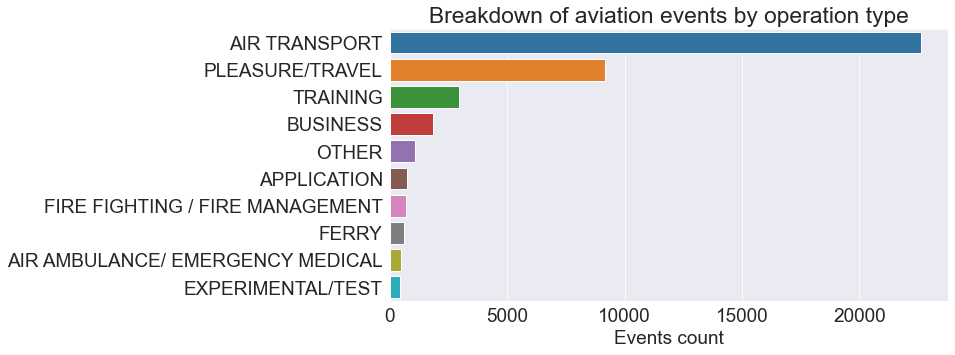

In [50]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'OperationTypeID_DisplayEng'
graph =  aircraft_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(10)
fig = sns.barplot(graph.values, graph.index);
fig.set(xlabel = 'Events count', ylabel = '', Title='Breakdown of aviation events by operation type');

The majority of events happen during air transport operations and pleasure/travel flights. This is expected, as these two categories represent the most frequent air operations.  

During search and rescue operations, evacuation time plays a significant role. In the following plot, we show a breakdown of reported evacuation times.

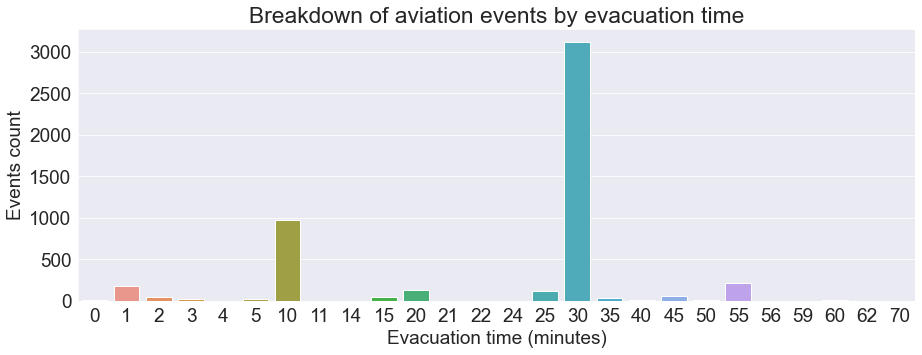

In [51]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'AircraftEvacTime'
data = survivability_df[survivability_df[column]<90].groupby(column).OccNo.count()
fig  = sns.barplot(x = data.index, y = data.values);
fig.set(xlabel = 'Evacuation time (minutes)', ylabel = 'Events count', Title='Breakdown of aviation events by evacuation time');
fig.set_xticklabels([int(x) for x in data.index]);


Let's look at the impact of evacuation time on fatal injuries count.

In [52]:
new_dataset2 = occurence_df.set_index('OccNo').join(survivability_df.set_index('OccNo'))
new_dataset2['AircraftEvacTimeCat'] = pd.cut(new_dataset2['AircraftEvacTime'], bins = [0,5,15,30,np.inf])

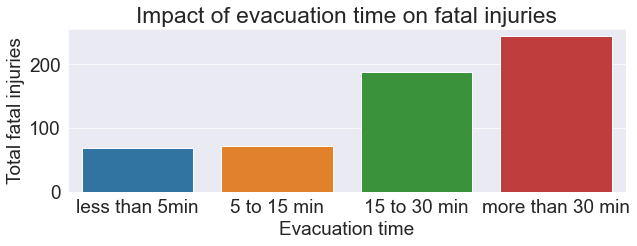

In [53]:

matplotlib.rcParams['figure.figsize'] = (10, 3)
column = 'AircraftEvacTimeCat'
data = new_dataset2.groupby(column)['TotalFatalCount'].sum()
fig = sns.barplot(x = data.index, y = data.values);
fig.set(xlabel = 'Evacuation time', ylabel = 'Total fatal injuries', Title='Impact of evacuation time on fatal injuries');
fig.set_xticklabels(['less than 5min','5 to 15 min','15 to 30 min', 'more than 30 min']);

As we might expect, more fatal injuries happen in situations where it takes longer to proceed with evacuation.  
Evacuation can be delayed due to multiple reasons, in addition to search time.  

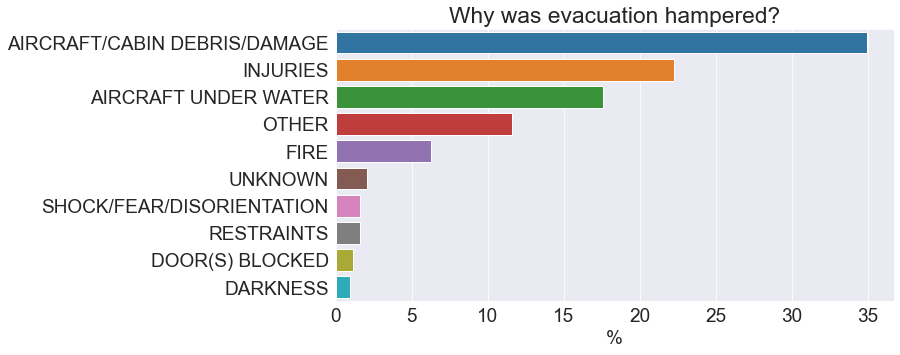

In [54]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'EvacHamperedID_DisplayEng'
graph =  survivability_df.groupby(column)['OccNo'].count().sort_values(ascending=False).head(10)
fig = sns.barplot(graph.values/sum(graph)*100, graph.index);
fig.set(xlabel = '%', ylabel = '', Title='Why was evacuation hampered?');

The availabilty of survival equipment has a great impact on incident outcome. Here is a breakdown of reported survival equipments in the dataset.

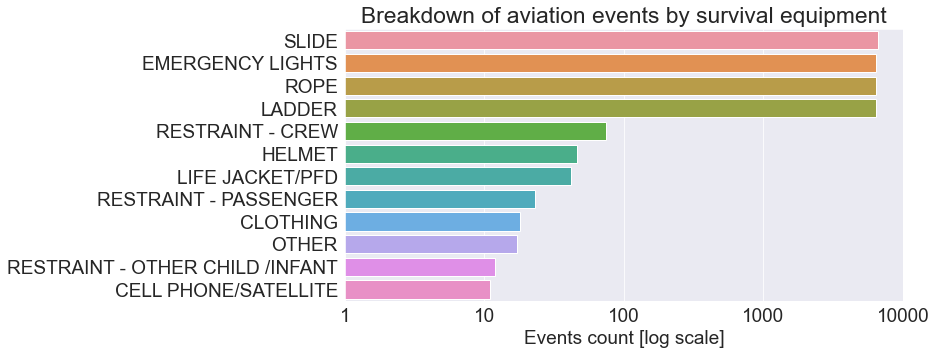

In [55]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'SurvEquiID_DisplayEng'
graph =  survivability_df_full.groupby(column)['OccNo'].count().sort_values(ascending=False).head(12)
fig = sns.barplot(graph.values, graph.index);
fig.set_xscale("log");
fig.set(xlabel = 'Events count [log scale]', ylabel = '', Title='Breakdown of aviation events by survival equipment');
fig.set_xticks([1,10,100,1000,10000]);
fig.set_xticklabels([1,10,100,1000,10000]);

Now let's see if the survival equipment was used properly during the events.

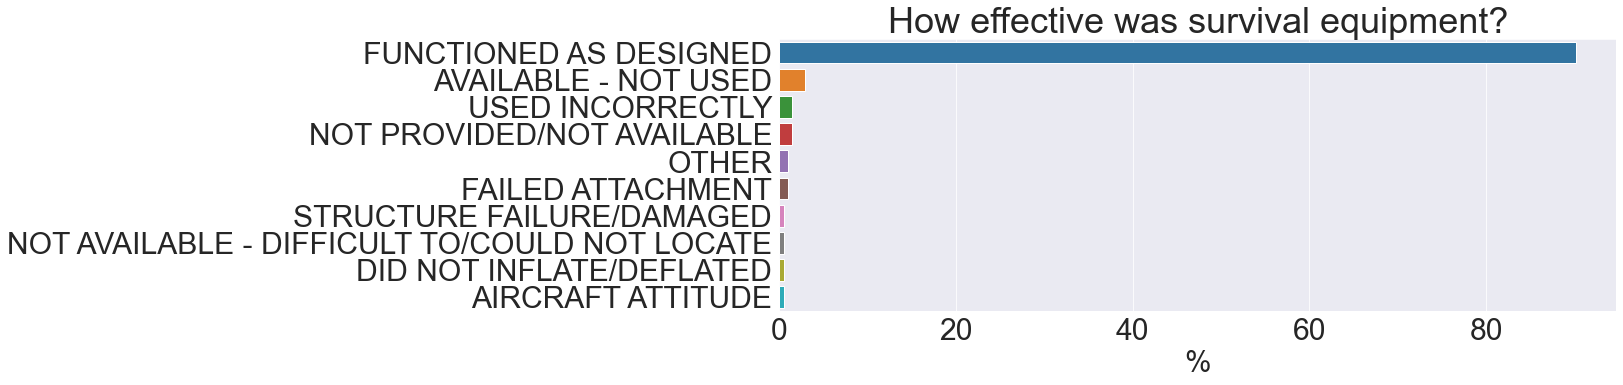

In [56]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
matplotlib.rcParams['font.size'] = 30
column = 'EquipEffReasonID_DisplayEng'
graph =  survivability_df[survivability_df[column]!='UNKNOWN'].groupby(column)['OccNo'].count().sort_values(ascending=False)
fig = sns.barplot(graph.values/sum(graph)*100, graph.index);
fig.set(xlabel = '%', ylabel = '', Title='How effective was survival equipment?');

This information is missing in a large number of reports. Nonetheless, it appears that -in a majority of cases- the survival equipment was used properly. Next question would be : how effective is the equipment ? 

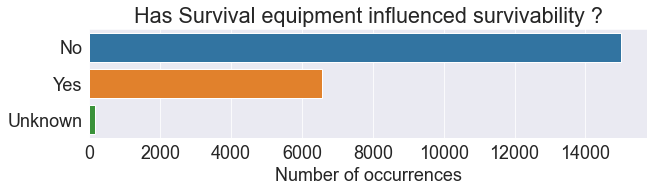

In [57]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
matplotlib.rcParams['font.size'] = 18
column = 'EquipInfluenceEnum_DisplayEng'
survivability_df[column] = survivability_df.fillna({column:'No'})[column]
fig = sns.countplot(y=column,data = survivability_df);
fig.set(xlabel = 'Number of occurrences', ylabel = '', Title='Has Survival equipment influenced survivability ?');

At first glance, we could observe that survival equipment didn't affect survivability in more than 14000 events. The **important statistic** here is that equipment was effective in more than 6000 events, so it saved *at least* 6000 lives !

## References
### Columns descriptions :  
**EquipInfluenceEnum_DisplayEng**  : Indicates whether the equipment influenced the survivability of the occurrence, if known, in English. <br>
**YearOfManuf**  : The year in which the aircraft was manufactured. <br>
**FlightPlanTypeID_DisplayEng**  : The type of flight plan, in English. <br>
**CountryID_DisplayEng**  : The country of the occurrence, in English. <br>
**TotalSeriousCount**  : The total number of serious injuries (includes any ground injuries). <br>
**InjuriesEnum_DisplayEng**  : Indicates whether there were any injuries related to the occurrence, including ground injuries, in English. <br>
**EquipEffectiveEnum_DisplayEng**  : Indicates whether equipment was effective and corresponds to the survival equipment, if known, in English. <br>
**OccIncidentTypeID_DisplayEng**  : If the occurrence is a reportable incident, the type of incident as defined in the Transportation Safety Board Regulations, Part 1, Subparagraph 2(1)(b), in English. <br>
**ICAO_DisplayEng**  : The International Civil Aviation Organization (ICAO) occurrence category, in English.
For one occurrence, multiple ICAO categories may be assigned, that will generate multiple entries/rows. <br>
**DamageLevelID_DisplayEng**  : The aircraft level of damage as defined by ICAO, in English. <br>
**PhaseID_DisplayEng**  : The phase of the flight, in English.
Note: Multiple phases can be assigned to each occurrence (OccID) or specific aircraft (AcID) and each will have an associated EventID. <br>
**OperationTypeID_DisplayEng**  : The type of operation performed at the time of the occurrence, in English. <br>
**EvacEgressIssueEnum_DisplayEng**  : Indicates whether there were evacuation egress issues, if known, in English. <br>
**SurvivableEnum_DisplayEng**  : Indicates whether the occurrence was survivable (for occurrences involving an impact), in English. Indicator: Yes/No/Unknown. <br>
**OccRegionID_DisplayEng**  : The region of the occurrence, as defined by the geographical area each regional office has been assigned, in English. <br>
**SkyCondID_DisplayEng**  : The sky conditions at the time of the occurrence, in English. <br>
**VisibilyCeiling**  : The visibility ceiling, in feet. <br>
**OccDate**  : The occurrence date. Date format is YYYY-MM-DD. <br>
**TotalFatalCount**  : The total number of fatalities (includes any ground fatalities). <br>
**SurfaceContaminationID_DisplayEng**  : The type of surface contamination, if relevant, in English.
Note: Each description will result in a separate entry. <br>
**OrganizationID_DisplayEng**  : The name of the organization (if the operator is an organization), in English. <br>
**GeneralWeatherID_DisplayEng**  : Indicates whether the known weather conditions were conducive to visual or instrument flight rules, in English. <br>
**RunwaySurfaceID_DisplayEng**  : The texture of the surface of the runway involved in the occurrence, in English. <br>
**EquipEffReasonID_DisplayEng**  : The reason for survival equipment effectiveness, in English. <br>
**EvacHamperedID_DisplayEng**  : The reason(s) why the evacuation was hampered, if applicable, in English. <br>
**OperatorTypeID_DisplayEng**  : The type of operator (private, commercial, state) involved in the occurrence, in English. <br>
**WeatherPhenomenaTypeID_DisplayEng**  : The type of weather phenomena at the time of the occurrence, in English.
Weather phenomena grid - Multiple weather phenomenas can be specified for each occurrence (OccID), each type and its associated description will appear as a separate entry. <br>
**OccTime**  : The time the occurrence happened. Time format is hh:mm (24-hour clock). <br>
**OccNo**  : The unique occurrence number for general reference. <br>
**SurvEquiID_DisplayEng**  : The survival equipment available on the occurrence aircraft, if relevant, in English.
Equipment grid - Multiple survival equipments can be assigned to an occurrence (OccID). Each equipment will result in a separate entry. <br>
**TimeZoneID_DisplayEng**  : The time zone used for reporting the time of occurrence, in English. <br>
**LightCondID_DisplayEng**  : A description of the light conditions, in English. <br>
**AircraftTypeID_DisplayEng**  : The aircraft type as defined in the Canadian Aviation Regulations, Part 1, Subpart 1. <br>
**AircraftModelID_DisplayEng**  : The aircraft model, in English. <br>
**OccTypeID_DisplayEng**  : A description of the occurrence type (accident/incident reportable), in English. <br>
**AircraftMakeID_DisplayEng**  : The aircraft make, in English. <br>
**Visibility**  : The visibility, in statute miles. <br>
**AircraftEvacTime**  : The duration of the aircraft evacuation, in minutes. <br>
**Summary**  : The summary of the occurrence. <br>